In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [3]:
data_path = "/Users/justinvega/Documents/Columbia/exoplanets/csvs/"
file = "gridparams_full.parquet.gzip"

df = pd.read_parquet(data_path + file, engine='fastparquet')

In [4]:
df.head()

,file,radius,period,a,b,t0,t12,t23,t14,u,f,phi,SNR,SNR_prime,RMS_noingress
0,r0.169-a_55.798-b_0.000-period2.415-f0.500-phi...,0.168889,2.414520,55.798032,3.416644e-15,0,0.002327,0.011448,0.016102,0.0,0.500000,0.349066,5.912227e-05,5.812407e-05,1.366240e-15
1,r0.071-a_55.798-b_0.433-period0.890-f0.389-phi...,0.070556,0.889517,55.798032,4.333333e-01,0,0.000398,0.004173,0.004968,0.0,0.388889,0.349066,1.081182e-04,8.435717e-05,8.254048e-04
2,r0.071-a_2.000-b_0.433-period2621.607-f0.500-p...,0.070556,2621.606561,2.000000,4.333333e-01,0,37.761194,362.739297,438.261684,0.0,0.500000,2.792527,5.103985e-04,4.968444e-04,1.216870e-13
3,r0.005-a_2.000-b_0.578-period48.290-f0.222-phi...,0.005000,48.290406,2.000000,5.777778e-01,0,0.054367,6.714642,6.823375,0.0,0.222222,2.094395,1.411280e-07,1.377701e-07,1.760224e-12
4,r0.234-a_7.573-b_0.289-period0.328-f0.444-phi1...,0.234444,0.327701,7.572958,2.888889e-01,0,0.003413,0.009787,0.016613,0.0,0.444444,1.047198,8.306537e-05,8.207250e-05,1.741142e-05


In [5]:
X = df[['radius', 'period', 'a', 'b', 'f', 'phi']]
Y = df["SNR"]
Y_alt = df["SNR_prime"]
Y_alt_2 = df["RMS_noingress"]
X = StandardScaler().fit_transform(X)

Evaluating if there are any major clusters of noise that might influence the result:

In [7]:
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

Although this simulation data was produced, there are some simulations that yield inconsistent SNRs (due to a systematic error in the fitting procedure for the lightcurve (transit signal)). I am first curious to figure out how inconsistent my simulations are, and see how observations compare to their nearest-neighbors. I consider looking at both the mean and median of the nearest-neighbors:

In [15]:
def local_median(X, Y, k):
    
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.6)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5)
    
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree')
    knn.fit(X_train)
    distances, indices = knn.kneighbors(X_train)

    Y_train_log = np.log10(Y_train.values)

    neighbor_indices = indices[:, 1:]
    neighbor_median_y = np.median(Y_train_log[neighbor_indices]) # median of the nearest neighbors for each observation

    y_deviation = np.abs(Y_train_log - neighbor_median_y) # how much does each point deviate from the median of its neighbors?

    threshold_67 = np.percentile(y_deviation, 67)
    threshold_95 = np.percentile(y_deviation, 95)
    bad_mask = y_deviation > threshold_67 # bad = outside of 66th percentile

    # Results
    print(f"Number of suspected bad y values: {np.sum(bad_mask)}")
    
    return(y_deviation, threshold_67, threshold_95)

def local_mean(X, Y, k):
    
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.6)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5)
    
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree')
    knn.fit(X_train)
    distances, indices = knn.kneighbors(X_train)
    
    Y_train_log = np.log10(Y_train.values)

    neighbor_indices = indices[:, 1:]
    neighbor_mean_y = np.mean(Y_train_log[neighbor_indices]) # mean of the nearest neighbors for each observation

    y_deviation = np.abs(Y_train_log - neighbor_mean_y) # how much does each point deviate from the mean of its neighbors?

    threshold_67 = np.percentile(y_deviation, 67)
    threshold_95 = np.percentile(y_deviation, 95)
    bad_mask = y_deviation > threshold_67 # bad = outside of 66th percentile

    # Results
    print(f"Number of suspected bad y values: {np.sum(bad_mask)}")
    
    return(y_deviation, threshold_67, threshold_95)

In [9]:
results = {'k': [10, 100, 200, 500, 1000], 'ydevs': [], 'threshold_67': [], 'threshold_95': []}

for idx, i in enumerate(results['k']):
    print(f"i = {i}")
    y_deviation, threshold_67, threshold_95 = local_mean(X_train, Y_train, int(i))
    # print(f"Threshold 67: {threshold_67}, Threshold 95: {threshold_95}")
    results['ydevs'].append(y_deviation)
    results['threshold_67'].append(threshold_67)
    results['threshold_95'].append(threshold_95)

i = 10
Number of suspected bad y values: 83160
i = 100
Number of suspected bad y values: 83160
i = 200
Number of suspected bad y values: 83160
i = 500
Number of suspected bad y values: 83160
i = 1000
Number of suspected bad y values: 83160


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


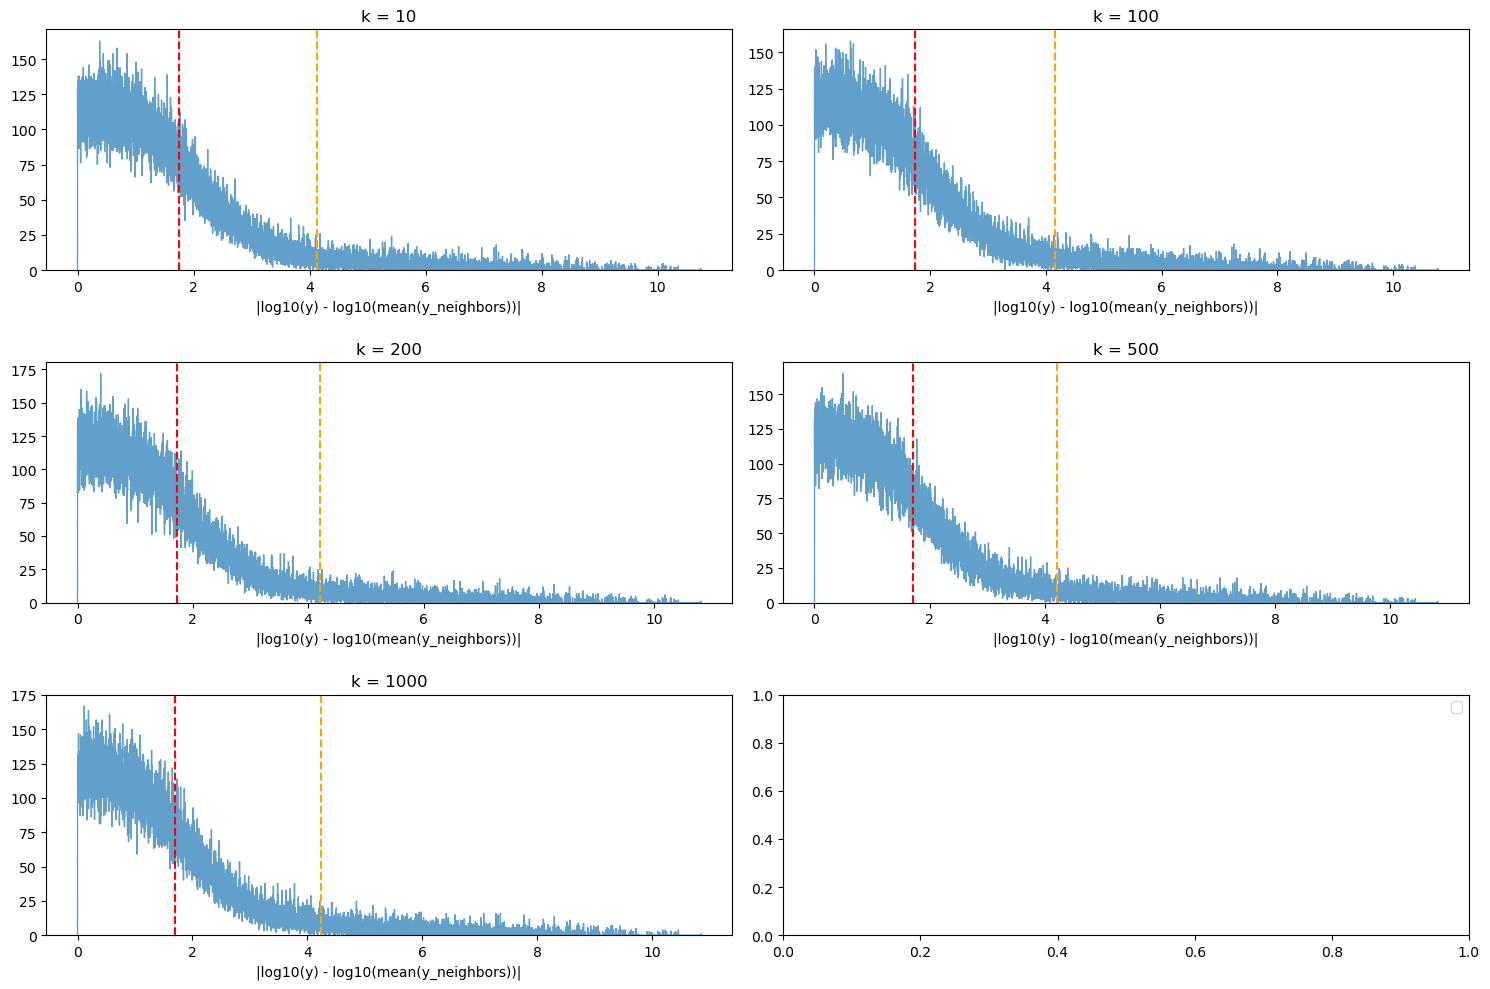

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax = ax.ravel()

for idx, i in enumerate(results['k']):
# Plotting
    ax[idx].hist(results["ydevs"][idx], bins = 10000, alpha = 0.7, histtype='step')
    ax[idx].axvline(results['threshold_67'][idx], color='red', linestyle='--', label='Threshold (67th percentile)')
    ax[idx].axvline(results['threshold_95'][idx], color='orange', linestyle='--', label='Threshold (95th percentile)')
    ax[idx].set_title(f'k = {int(i)}')
    ax[idx].set_xlabel('|log10(y) - log10(mean(y_neighbors))|')

plt.legend()
fig.tight_layout(h_pad=2)
    

In [16]:
results_med = {'k': [10, 100, 200, 500, 1000], 'ydevs': [], 'threshold_67': [], 'threshold_95': []}

for idx, i in enumerate(results_med['k']):
    print(f"i = {i}")
    y_deviation, threshold_67, threshold_95 = local_median(X, Y, int(i))
    # print(f"Threshold 67: {threshold_67}, Threshold 95: {threshold_95}")
    results_med['ydevs'].append(y_deviation)
    results_med['threshold_67'].append(threshold_67)
    results_med['threshold_95'].append(threshold_95)

i = 10
Number of suspected bad y values: 83160
i = 100
Number of suspected bad y values: 83160
i = 200
Number of suspected bad y values: 83160
i = 500
Number of suspected bad y values: 83160
i = 1000
Number of suspected bad y values: 83160


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


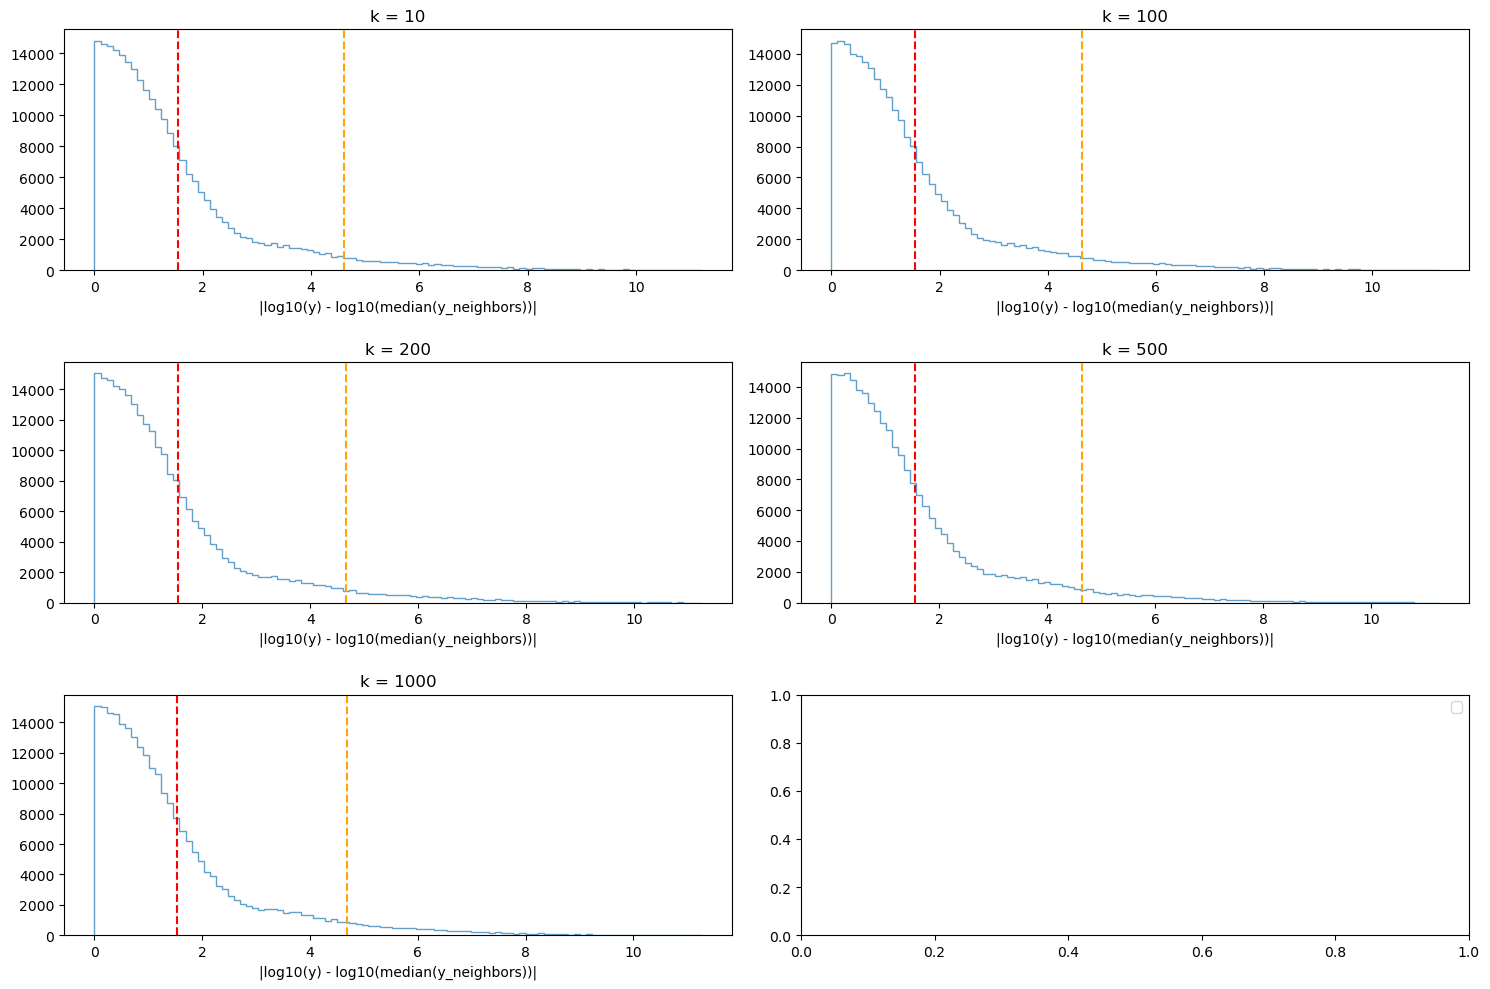

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax = ax.ravel()

for idx, i in enumerate(results_med['k']):
# Plotting
    ax[idx].hist(results_med["ydevs"][idx], bins = 100, alpha = 0.7, histtype='step')
    ax[idx].axvline(results_med['threshold_67'][idx], color='red', linestyle='--', label='Threshold (67th percentile)')
    ax[idx].axvline(results_med['threshold_95'][idx], color='orange', linestyle='--', label='Threshold (95th percentile)')
    ax[idx].set_title(f'k = {int(i)}')
    ax[idx].set_xlabel('|log10(y) - log10(median(y_neighbors))|')

plt.legend()
fig.tight_layout(h_pad=2)
    

Number of suspected bad y values: 83160


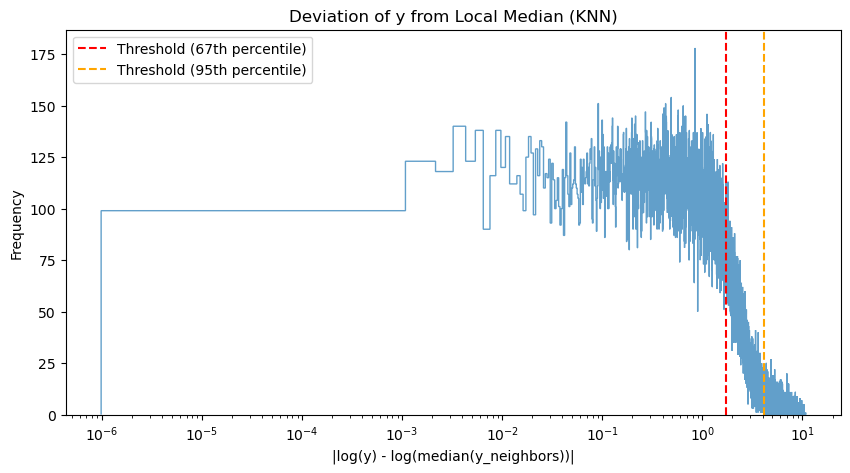

In [ ]:
# y_deviation, threshold_67, threshold_95 = local_mean(Y_train)
# plt.figure(figsize=(10, 5))
# plt.hist(y_deviation, bins=10000, alpha=0.7, histtype='step')
# plt.axvline(threshold_67, color='red', linestyle='--', label='Threshold (67th percentile)')
# plt.axvline(threshold_95, color='orange', linestyle='--', label='Threshold (95th percentile)')
# plt.title('Deviation of y from Local Median (KNN)')
# plt.xlabel('|log(y) - log(median(y_neighbors))|')
# plt.ylabel('Frequency')
# plt.xscale('log')
# # plt.ylim(0, 2.5e4)
# plt.legend()
# plt.show()

### Tune hyperparameters

In [ ]:
# # kernel ridge regression function using sklearn
# def kernel_ridge_regression(X_train: np.ndarray, 
#                             y_train: np.ndarray,
#                             X_test: np.ndarray,
#                             kernel_function):
    
#     param_distributions = {
#         'alpha': np.logspace(-2, 1, 30),
#         'gamma': np.logspace(-1, 2, 10),
#         }
    
#     if kernel_function == 'poly':
#         print("Polynomial kernel")
#         kernel_ridge = KernelRidge(kernel='polynomial')
#         del param_distributions['gamma']
#         param_distributions['degree'] = np.arange(2, 5)
        
#     elif kernel_function == 'rbf':
#         print("RBF kernel")
#         kernel_ridge = KernelRidge(kernel=RBF())
        
#     # find the best hyperparameter
#     kernel_ridge_tuned = RandomizedSearchCV(
#         kernel_ridge,
#         param_distributions=param_distributions,
#         n_iter=100,
#         n_jobs = 1,
#         scoring='neg_mean_squared_error',
#     )
    
#     kernel_ridge_tuned.fit(X_train, y_train)
#     best_alpha = kernel_ridge_tuned.best_params_['alpha']
    
#     if kernel_function == 'rbf':
#         best_gamma = kernel_ridge_tuned.best_params_['gamma']
#         print(f"Best gamma: {best_gamma}")
#     else:
#         best_degree = kernel_ridge_tuned.best_params_['degree']
#         print(f"Best degree: {best_degree}")
    
#     ytest_pred = kernel_ridge_tuned.predict(X_test)
#     print(f"Best alpha: {best_alpha}")
    
#     return ytest_pred

In [ ]:
# ytest_pred = kernel_ridge_regression(X_train, Y_train, X_test, 'rbf')
# mse_rbf = mean_squared_error(Y_test, ytest_pred)
# print(f"Mean squared error: {mse_rbf}")

RBF kernel


KeyboardInterrupt: 

In [ ]:
# ytest_pred = kernel_ridge_regression(X_train, Y_train, X_test, 'poly')
# mse_poly = mean_squared_error(Y_test, ytest_pred)
# print(f"Mean squared error: {mse_poly}")